# Logistic Regression Pipeline for HeLa (GREG)

### Author: Shaurya Jauhari (Mora Lab)
### Contact: Antonio Mora (antoniocmora@gzhmu.edu.cn)
### Last Reviewed : Dec. 8th, 2020

## Prologue

This notebook assesses variegated implementations of the logistic regression models for the data derived from the HeLa cell-line in GREG. The data for this and other cell-types for GREG is available at this <a href = "https://zenodo.org/record/6339915"> link</a>. The current notebook uses the file "HeLaforML.txt".

## Contents

* [1. Loading Packages](#link1)
* [2. Loading Data](#link2)
* [3. Building Model](#link3)
* [4. Dealing with the *Paradox* of Accuracy ](#link4)
    * [4.1 Problem of Class Imbalance](#link5)
        * [4.1.1 Oversampling of minority class](#link6)
        * [4.1.2 Undersampling of minority class](#link7)
        * [4.1.3 SMOTE](#link8)
        * [4.1.4 Both over- and under-sampling](#link9)
* [5. Ratifying the *Pareto's Principle*](#link10)
    * [5.1 SMOTE data](#link11)
* [6. Visualizing Predictions](#link12)
* [7. Session Information](#link13)

### <a id=link1>1. Loading Packages </a>

In [12]:
requiredPackages <- c("glmnet", "rms", "caret", "e1071", "ROSE", "DMwR", "BiocManager", "ROCR")
newPackages <- requiredPackages[!(requiredPackages %in% installed.packages()[,"Package"])]
if(length(newPackages)) install.packages(newPackages, dependencies = TRUE)

suppressPackageStartupMessages(library(glmnet))
suppressPackageStartupMessages(library(rms))
suppressPackageStartupMessages(library(caret))
suppressPackageStartupMessages(library(e1071))
suppressPackageStartupMessages(library(ROSE))
suppressPackageStartupMessages(library(DMwR))
suppressPackageStartupMessages(library(ROCR))

### <a id=link2>2. Loading Data </a>

In [2]:
helagregStandard <- read.table("HeLaforML.txt", header = TRUE) ## loading data
helagreg<- helagregStandard[, -c(1:3)] ## removing the first three columns for non-usage in the ML model.

In [3]:
head(helagreg)

,CTCF,EP300,H3K27me3,H3K36me3,H3K4me1,H3K4me2,H3K4me3,H3K9ac,H3K9me3,RAD21,RNA.Seq,RNAPol2,RNAPol3,Class
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,0.00000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.000000,0.00000000,0.00000000,0,0.000000,0.00000000,Non-Hub
2,0.00000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.000000,0.00000000,0.00000000,0,0.000000,0.00000000,Non-Hub
3,0.00000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.000000,0.00000000,0.00000000,0,0.000000,0.00000000,Non-Hub
4,0.00000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.000000,0.00000000,0.00000000,0,0.000000,0.00000000,Non-Hub
5,0.00000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.000000,0.00000000,0.00000000,0,0.000000,0.07964071,Non-Hub
6,16.31532,0.3485739,0.7310137,0.5121474,0.2671445,0.9937343,0.8823614,1.233227,0.03706458,0.08740367,0,1.506197,13.00798194,Non-Hub


<p align = "justify"><i> cv.glmnet </i> is a function that performs cross-validation and engenders different values of lambda (mean cross-validation error). The default value for a CV-run is 10, meaning thereby that the data is partitioned in 10 near-equal subsets. At every iteration, the model is trained with the 9 folds and the remaining fold is used for testing. A lambda value represents the prediction error for every train-test case. The number of folds are tuneable (<i>nfolds</i> parameter).</p> 

Warning message:
“from glmnet Fortran code (error code -2); Convergence for 2th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -2); Convergence for 2th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -2); Convergence for 2th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -2); Convergence for 2th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -2); Convergence for 2th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -2); Convergence for 2th lambda value not reached after maxit=100000 i

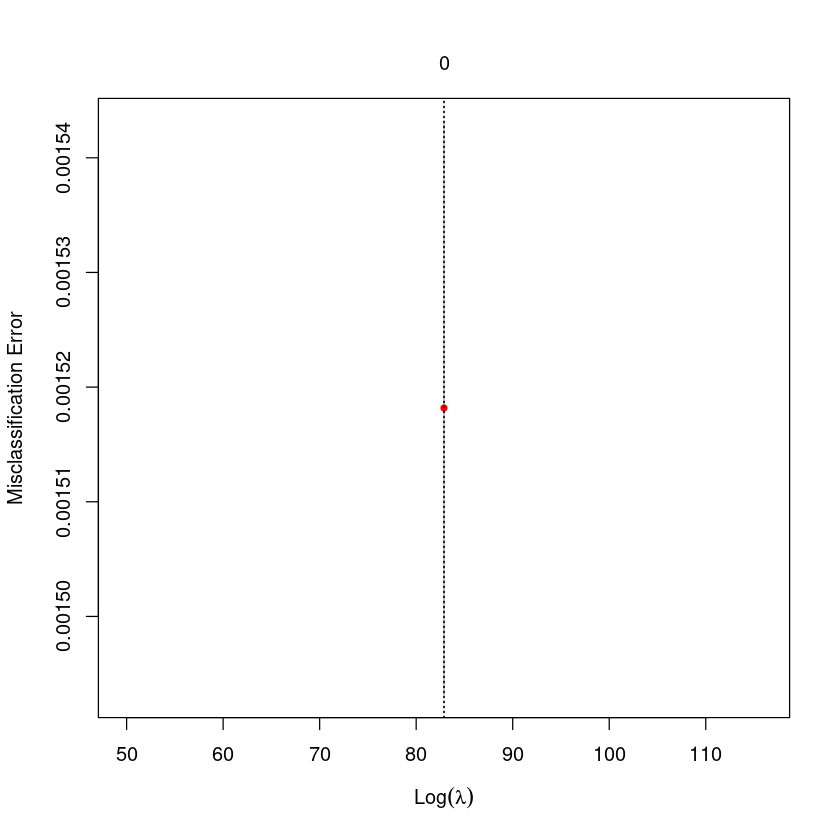

In [4]:
set.seed(005)
cv.modelfit <- cv.glmnet(as.matrix(helagreg[,1:13]),
                         helagreg$Class,
                         family = "binomial",
                         type.measure = "class",
                         alpha = 1,
                         nlambda = 20,
                         nfolds = 20)


plot(cv.modelfit)

In [5]:
coef(cv.modelfit)

14 x 1 sparse Matrix of class "dgCMatrix"
                   1
(Intercept) 6.488725
CTCF        0.000000
EP300       .       
H3K27me3    .       
H3K36me3    .       
H3K4me1     .       
H3K4me2     .       
H3K4me3     .       
H3K9ac      .       
H3K9me3     .       
RAD21       .       
RNA.Seq     .       
RNAPol2     .       
RNAPol3     .       

In [6]:
cat("There are", length(cv.modelfit$lambda),
    "lambda values in all:\n",
    cv.modelfit$lambda,
    "\n, out of which",
    min(cv.modelfit$lambda),
    "is the minimum, while",
    cv.modelfit$lambda.1se,
    "denotes the value at which the model is optimized at one standard error.")

There are 1 lambda values in all:
 9.9e+35 
, out of which 9.9e+35 is the minimum, while 9.9e+35 denotes the value at which the model is optimized at one standard error.

### <a id=link3>3. Building Model </a>

In [7]:
set.seed(2)
modelfit <- glmnet(as.matrix(helagreg[,1:13]),
                   helagreg$Class,
                   family = "binomial",
                   alpha = 1,
                   lambda = min(cv.modelfit$lambda))
# Listing non-zero coefficients
print(modelfit$beta[,1])

    CTCF    EP300 H3K27me3 H3K36me3  H3K4me1  H3K4me2  H3K4me3   H3K9ac 
       0        0        0        0        0        0        0        0 
 H3K9me3    RAD21  RNA.Seq  RNAPol2  RNAPol3 
       0        0        0        0        0 


For a standard usage, supplying a single <i>lambda</i> value is not advisable (See <a href= "https://cran.r-project.org/web/packages/glmnet/glmnet.pdf" > here</a>). There could be a convergence issue, as above, and so the better ways is to have the function decide for itself amongst an array of values. Let us attempt again, with the new theme.

In [8]:
set.seed(3)
modelfit <- glmnet(as.matrix(helagreg[,1:13]),
                   helagreg$Class,
                   family = "binomial",
                   alpha = 1,
                   lambda = cv.modelfit$lambda)
# Listing non-zero coefficients
print(modelfit$beta[,1])

    CTCF    EP300 H3K27me3 H3K36me3  H3K4me1  H3K4me2  H3K4me3   H3K9ac 
       0        0        0        0        0        0        0        0 
 H3K9me3    RAD21  RNA.Seq  RNAPol2  RNAPol3 
       0        0        0        0        0 


In [9]:
coef(modelfit)[,1]
predict(modelfit, type="coef")

(Intercept)        CTCF       EP300    H3K27me3    H3K36me3     H3K4me1 
   6.488725    0.000000    0.000000    0.000000    0.000000    0.000000 
    H3K4me2     H3K4me3      H3K9ac     H3K9me3       RAD21     RNA.Seq 
   0.000000    0.000000    0.000000    0.000000    0.000000    0.000000 
    RNAPol2     RNAPol3 
   0.000000    0.000000

14 x 1 sparse Matrix of class "dgCMatrix"
                  s0
(Intercept) 6.488725
CTCF        0.000000
EP300       .       
H3K27me3    .       
H3K36me3    .       
H3K4me1     .       
H3K4me2     .       
H3K4me3     .       
H3K9ac      .       
H3K9me3     .       
RAD21       .       
RNA.Seq     .       
RNAPol2     .       
RNAPol3     .       

In [10]:
set.seed(4) # for reproducibility of results.

helagreg$Class <- as.numeric(as.factor(helagreg$Class))
helagreg$Class <- ifelse(helagreg$Class == 2, 0, 1)
table(helagreg$Class)


      0       1 
1516620    2306 

Converting to the numerical equivalents (representation), Non-Hubs have been reduced to the value "0", and Hubs to "1".

In [11]:
part <- sample(2, nrow(helagreg),
               replace = TRUE,
               prob = c(0.7,0.3))
train <- helagreg[part==1,]
test <- helagreg[part==2,]
cat("So, now we have",
    nrow(train),
    "training rows and",
    nrow(test),
    "testing rows")

helamodel <- glm(formula = Class ~ .,
               data = train,
               family = "binomial")
summary(helamodel)

So, now we have 1063189 training rows and 455737 testing rows

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



Call:
glm(formula = Class ~ ., family = "binomial", data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.0933  -0.0564  -0.0549  -0.0519   3.9027  

Coefficients:
              Estimate Std. Error  z value Pr(>|z|)    
(Intercept) -6.4777203  0.0352932 -183.540  < 2e-16 ***
CTCF        -0.0429154  0.0163365   -2.627  0.00861 ** 
EP300       -0.0064907  0.0036908   -1.759  0.07865 .  
H3K27me3    -0.2322200  0.0314926   -7.374 1.66e-13 ***
H3K36me3     0.1337062  0.0225953    5.917 3.27e-09 ***
H3K4me1      0.1120906  0.0119630    9.370  < 2e-16 ***
H3K4me2     -0.0193594  0.0138221   -1.401  0.16133    
H3K4me3      0.0223866  0.0151659    1.476  0.13991    
H3K9ac       0.0069828  0.0119912    0.582  0.56035    
H3K9me3     -0.0684054  0.0447245   -1.529  0.12614    
RAD21        0.0361151  0.0088728    4.070 4.69e-05 ***
RNA.Seq      0.0002798  0.0004578    0.611  0.54107    
RNAPol2      0.0022652  0.0033201    0.682  0.49508    
RNAPol3     -0.00014

<h5> Variance Inflation Factors(VIF) </h5>


<p align= "justify"> The state of <a href = "https://www.investopedia.com/terms/m/multicollinearity.asp" > multicollinearity</a> is a common check enroute building of an effective regression model. When two or more predictor(independent) variables are correlated with each other, they do not offer much to the model structure and kind of induce <i>redundancy</i>.</p>
<p align="justify"> A general guideline is that a VIF larger than 5, then that predictor is more related to the other predictors than it is to the response. Contrarily, a VIF value of 1 for a predictor variable indicates that there is no correlation with other predictors, and a VIF value between 1 and 5 is representative of a moderate correlation. <b>The user can choose to remove the independent variables with a high VIF and a high p-value</b>.</p>

In [13]:
vif(helamodel)

CTCF     EP300  H3K27me3  H3K36me3   H3K4me1   H3K4me2   H3K4me3    H3K9ac 
 5.989462  2.306153 15.119464 14.679885  3.140537  6.871682 10.931912  8.601231 
  H3K9me3     RAD21   RNA.Seq   RNAPol2   RNAPol3 
 1.814682  3.103366  1.021214  1.799090  1.646538

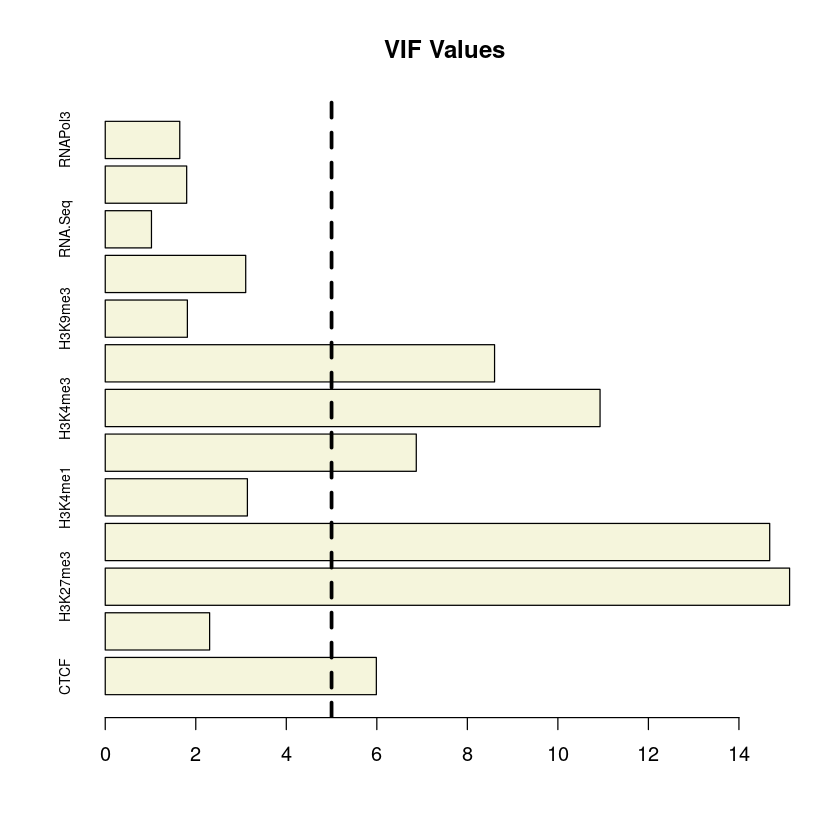

In [14]:
#create horizontal bar chart to display each VIF value
barplot(vif(helamodel), main = "VIF Values", horiz = TRUE, col = "beige", cex.names=.7)

#add vertical line at 5
abline(v = 5, lwd = 3, lty = 2)

Initial observation is that amongst others, the variable <b>H3K4me2</b>, <b>H3K4me3</b>, and <b>H3K9ac</b> have a high p-value and relatively high VIF. In such a case, these can be omitted from the model.

In [15]:
helamodel1 <- glm(formula = Class ~ CTCF + EP300 + H3K27me3 + H3K36me3 + H3K4me1 + H3K9me3 + RAD21 + RNA.Seq + RNAPol2 + RNAPol3,
               data = train,
               family = "binomial")
summary(helamodel1)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



Call:
glm(formula = Class ~ CTCF + EP300 + H3K27me3 + H3K36me3 + H3K4me1 + 
    H3K9me3 + RAD21 + RNA.Seq + RNAPol2 + RNAPol3, family = "binomial", 
    data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.6372  -0.0565  -0.0552  -0.0520   3.9130  

Coefficients:
              Estimate Std. Error  z value Pr(>|z|)    
(Intercept) -6.4734885  0.0351001 -184.429  < 2e-16 ***
CTCF        -0.0224393  0.0132442   -1.694 0.090214 .  
EP300       -0.0059352  0.0036119   -1.643 0.100330    
H3K27me3    -0.2426261  0.0306350   -7.920 2.38e-15 ***
H3K36me3     0.1251277  0.0219410    5.703 1.18e-08 ***
H3K4me1      0.1162102  0.0105832   10.981  < 2e-16 ***
H3K9me3     -0.0671202  0.0445909   -1.505 0.132261    
RAD21        0.0316146  0.0084528    3.740 0.000184 ***
RNA.Seq      0.0003837  0.0004256    0.901 0.367347    
RNAPol2      0.0048134  0.0015522    3.101 0.001928 ** 
RNAPol3      0.0005671  0.0042925    0.132 0.894898    
---
Signif. codes:  0 ‘***’ 0.0

In [16]:
# Examine the VIF for the variables in the new model.
vif(helamodel1)

CTCF     EP300  H3K27me3  H3K36me3   H3K4me1   H3K9me3     RAD21   RNA.Seq 
 4.286340  2.267072 15.147141 14.619347  2.636639  1.835996  2.887498  1.007810 
  RNAPol2   RNAPol3 
 1.024716  1.593891

This seems a good improvisation than before as just two variables (<i>H3K27me3</i> and <i>H3K36me3</i>) demonstrate a high p-value, but an acceptable VIF. We'll stick to this model.

In [17]:
yTrain <- predict(helamodel1, train, type = "response")
head(yTrain)

1            2            3            4            6           10 
0.0015414509 0.0015414509 0.0015414509 0.0015414509 0.0009977658 0.0017382889

In [18]:
head(train)

,CTCF,EP300,H3K27me3,H3K36me3,H3K4me1,H3K4me2,H3K4me3,H3K9ac,H3K9me3,RAD21,RNA.Seq,RNAPol2,RNAPol3,Class
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.000000,0.00000000,0.00000000,0.00000,0.000000,0.0000000,0
2,0.000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.000000,0.00000000,0.00000000,0.00000,0.000000,0.0000000,0
3,0.000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.000000,0.00000000,0.00000000,0.00000,0.000000,0.0000000,0
4,0.000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.000000,0.00000000,0.00000000,0.00000,0.000000,0.0000000,0
6,16.315324,0.3485739,0.7310137,0.5121474,0.2671445,0.9937343,0.8823614,1.233227,0.03706458,0.08740367,0.00000,1.506197,13.0079819,0
10,1.112408,0.0000000,1.0082948,2.5363492,0.5046062,0.8233798,1.1974905,1.574332,0.00000000,0.00000000,12.20714,1.862927,0.5574849,0


The confusion matrix is
         Actual
Predicted      0      1
        0 455073    660
        1      4      0
The accuracy of the model is 99.8543 % 
The misclassification error of the model is 0.1456981 % 
The sensitivity of the model is 99.99912 % 
The specificity of the model is 0 % 
The area under curve is 0.4999956 
The statistical significance for the model is 2.846218e-37 
The confidence level for the model is 100 %

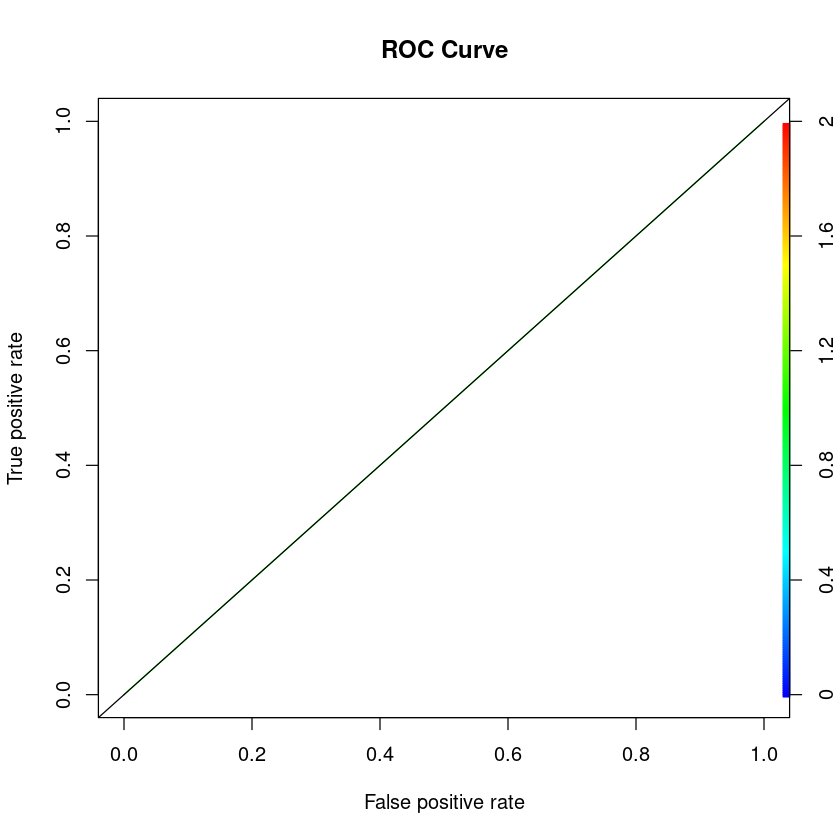

In [19]:
source("../../transcriptionFactoriesGREG/MachineLearning/R/modelPerformance.R")
modelPerformance(helamodel1, "lr", test, Class)

We tried to omit some variables on the basis of their significance, but we can clearly observe that the model has **zero specificity** and **high sensitivity** due to the class-imbalance problem in data. It means that the model is **highly biased towards the Non-Hubs** and that solely accounts for the data imbalance.

### <a id=link4>4. Dealing with the *Paradox* of Accuracy  </a>

The model is highly accurate in predicting the non-hubs individually. Since the data carries significant imbalance in the classes (non-hubs are far more in number than the hubs), the prediction for the hubs might not be well suited. We need to extend the analysis for a "balanced" data. But before we delve further, let us calculate the sensitivity and specificity parameters to check how well the model is able to identify positive class labels (1: hubs).

This is clearly not what we want.

####  <a id=link5>4.1 Problem of Class Imbalance </a>

The problem of class imbalance presents a warranting scenario for data normalization in terms of class proportions. Two simple strategies to mitigate this problem are oversampling and undersampling.

#####  <a id=link5> 4.1.1 Oversampling of minority class </a>

In [20]:
table(helagreg$Class)


      0       1 
1516620    2306 

We can articulate that the hubs(class marked with '0') are way less than the non-hubs. To scale them in proportion to the non-hubs, we can choose to oversample their instances. This is carried out by randomly choosing their exisiting data points and repeating to match a specified number. The package ***ROSE*** comes in handy here. The details about the package could be found [here](https://www.rdocumentation.org/packages/ROSE/versions/0.0-3).

In [21]:
overTrain <- ovun.sample(Class ~., data = train, method = "over", N = 1518926)$data

In [22]:
table(overTrain$Class)


      0       1 
1061543  457383 

Still better. Let's run the model again to see if there is any improvement in the performance.

In [23]:
helamodel1Over <- glm(formula = Class ~ CTCF + EP300 + H3K27me3 + H3K36me3 + H3K4me1 + H3K9me3 + RAD21 + RNA.Seq + RNAPol2 + RNAPol3,
               data = overTrain,
               family = "binomial")
summary(helamodel1Over)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



Call:
glm(formula = Class ~ CTCF + EP300 + H3K27me3 + H3K36me3 + H3K4me1 + 
    H3K9me3 + RAD21 + RNA.Seq + RNAPol2 + RNAPol3, family = "binomial", 
    data = overTrain)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-8.4904  -0.8227  -0.7889   1.4121   2.0683  

Coefficients:
              Estimate Std. Error  z value Pr(>|z|)    
(Intercept) -0.9778378  0.0029372 -332.913   <2e-16 ***
CTCF         0.0353469  0.0020226   17.476   <2e-16 ***
EP300        0.1209844  0.0027613   43.814   <2e-16 ***
H3K27me3    -0.2306379  0.0024355  -94.697   <2e-16 ***
H3K36me3     0.0889528  0.0019789   44.951   <2e-16 ***
H3K4me1      0.1458906  0.0017340   84.134   <2e-16 ***
H3K9me3     -0.0915526  0.0034969  -26.181   <2e-16 ***
RAD21        0.0137548  0.0010995   12.511   <2e-16 ***
RNA.Seq      0.0080972  0.0002492   32.498   <2e-16 ***
RNAPol2      0.0124905  0.0004097   30.490   <2e-16 ***
RNAPol3      0.0011223  0.0005347    2.099   0.0358 *  
---
Signif. codes:  0 ‘***’

In [24]:
vif(helamodel1Over)

CTCF    EP300 H3K27me3 H3K36me3  H3K4me1  H3K9me3    RAD21  RNA.Seq 
2.204520 1.778383 2.192747 2.110979 1.968724 1.339621 1.880686 1.085606 
 RNAPol2  RNAPol3 
1.084259 1.123512

The confusion matrix is
         Actual
Predicted      0      1
        0 444339    618
        1  10738     42
The accuracy of the model is 97.50821 % 
The misclassification error of the model is 2.491788 % 
The sensitivity of the model is 97.6404 % 
The specificity of the model is 6.363636 % 
The area under curve is 0.5200202 
The statistical significance for the model is 0 
The confidence level for the model is 100 %

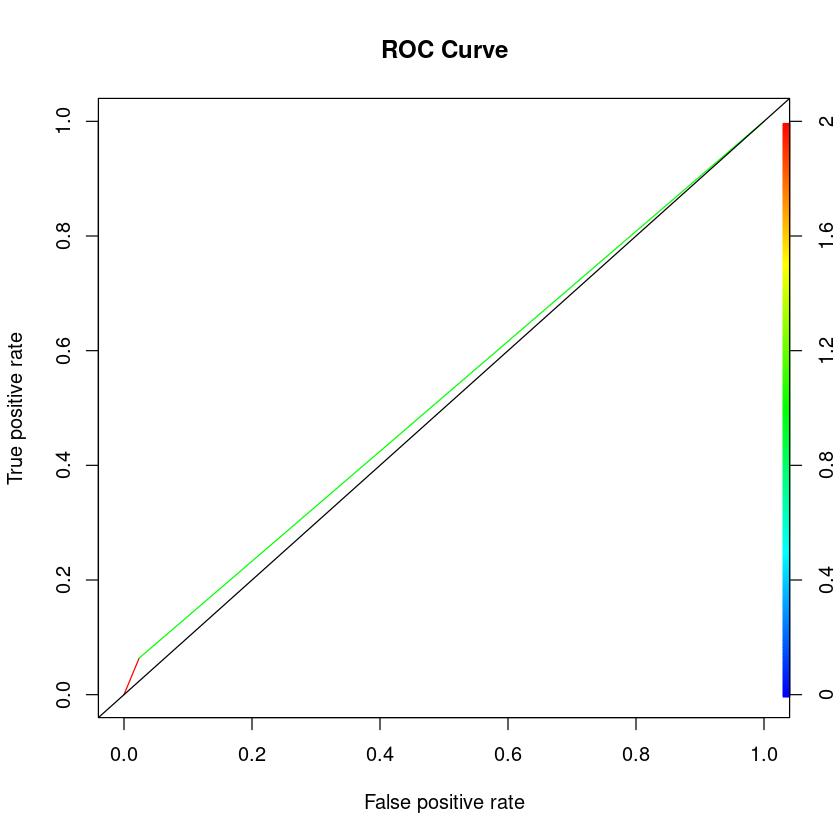

In [25]:
modelPerformance(helamodel1Over, "lr", test, Class)

This is better than before but still not good enough. Maybe we can try the other approach.

##### <a id=link5> 4.1.2 Undersampling of majority class  </a>

Contrary to what we did above, we shall now scale down the random data points from the majority class and see if the model performs any better.

In [26]:
underTrain <- ovun.sample(Class ~., data = train, method = "under", N = 3500)$data
table(underTrain$Class)


   0    1 
1854 1646 

In [27]:
helamodel1Under <- glm(formula = Class ~ CTCF + EP300 + H3K27me3 + H3K36me3 + H3K4me1 + H3K9me3 + RAD21 + RNA.Seq + RNAPol2 + RNAPol3,
               data = underTrain,
               family = "binomial")
summary(helamodel1Under)


Call:
glm(formula = Class ~ CTCF + EP300 + H3K27me3 + H3K36me3 + H3K4me1 + 
    H3K9me3 + RAD21 + RNA.Seq + RNAPol2 + RNAPol3, family = "binomial", 
    data = underTrain)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.8908  -1.0395  -0.9571   1.2316   1.5001  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.415958   0.062689  -6.635 3.24e-11 ***
CTCF         0.115369   0.052077   2.215 0.026736 *  
EP300        0.124106   0.065647   1.891 0.058690 .  
H3K27me3    -0.051731   0.057773  -0.895 0.370568    
H3K36me3     0.175399   0.045568   3.849 0.000119 ***
H3K4me1      0.212131   0.042468   4.995 5.88e-07 ***
H3K9me3     -0.269907   0.083138  -3.246 0.001168 ** 
RAD21        0.008832   0.026531   0.333 0.739226    
RNA.Seq      0.024355   0.007633   3.191 0.001420 ** 
RNAPol2      0.006282   0.008028   0.782 0.433932    
RNAPol3     -0.004417   0.008717  -0.507 0.612373    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.

In [28]:
vif(helamodel1Under)

CTCF    EP300 H3K27me3 H3K36me3  H3K4me1  H3K9me3    RAD21  RNA.Seq 
1.735862 1.714287 1.556442 1.421728 1.638705 1.921635 1.836426 1.085103 
 RNAPol2  RNAPol3 
1.124891 1.060340

The confusion matrix is
         Actual
Predicted      0      1
        0 387631    450
        1  67446    210
The accuracy of the model is 85.10193 % 
The misclassification error of the model is 14.89807 % 
The sensitivity of the model is 85.17921 % 
The specificity of the model is 31.81818 % 
The area under curve is 0.584987 
The statistical significance for the model is 1.190332e-34 
The confidence level for the model is 100 %

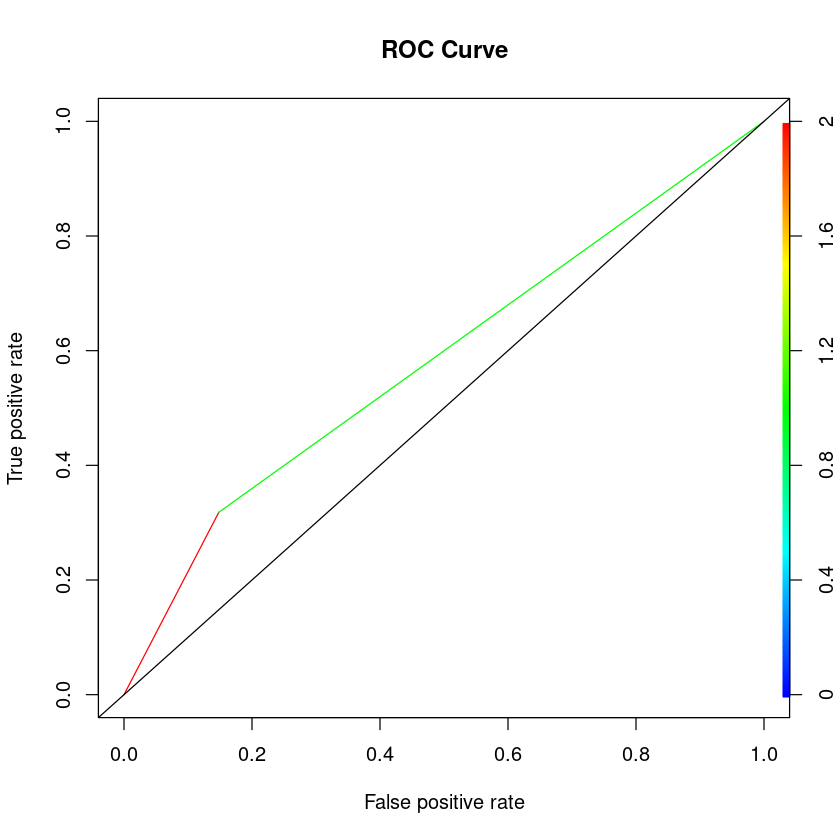

In [29]:
modelPerformance(helamodel1Under, "lr", test, Class)

Still better. How about the SMOTE transformation.

##### <a id=link8> 4.1.3 SMOTE  </a>

The sampling techniques are straighforward, but could possibly engender a classifier that overfits the training data and hence might not be suitable for a general application. To handle such a chance, [SMOTE](https://www3.nd.edu/~dial/publications/chawla2002smote.pdf) was introduced by Chawla et al. in 2002 and the functionality is available in R with the package *DMwR*.

In [30]:
## Smote : Synthetic Minority Oversampling Technique
## A pre-requisite is that the class variable in the data must be of "factor" category. Let's do that conversion.

train$Class <- as.factor(train$Class)

smoteData <- SMOTE(Class ~., train, perc.over = 100000, k = 5, perc.under = 100)

table(smoteData$Class)


      0       1 
1646000 1647646 

In [31]:
helamodel1SMOTE <- glm(formula = Class ~ CTCF + EP300 + H3K27me3 + H3K36me3 + H3K4me1 + H3K9me3 + RAD21 + RNA.Seq + RNAPol2 + RNAPol3,
               data = smoteData,
               family = "binomial")

summary(helamodel1SMOTE)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



Call:
glm(formula = Class ~ CTCF + EP300 + H3K27me3 + H3K36me3 + H3K4me1 + 
    H3K9me3 + RAD21 + RNA.Seq + RNAPol2 + RNAPol3, family = "binomial", 
    data = smoteData)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-8.4904  -1.0951   0.0336   1.1695   1.5880  

Coefficients:
              Estimate Std. Error  z value Pr(>|z|)    
(Intercept) -0.2597893  0.0022046 -117.841  < 2e-16 ***
CTCF         0.0458024  0.0015532   29.489  < 2e-16 ***
EP300        0.3253068  0.0029263  111.168  < 2e-16 ***
H3K27me3    -0.1631436  0.0018688  -87.300  < 2e-16 ***
H3K36me3     0.1057756  0.0014161   74.693  < 2e-16 ***
H3K4me1      0.1216022  0.0014042   86.601  < 2e-16 ***
H3K9me3     -0.1844694  0.0026833  -68.748  < 2e-16 ***
RAD21        0.0021774  0.0008286    2.628   0.0086 ** 
RNA.Seq      0.0088674  0.0001802   49.216  < 2e-16 ***
RNAPol2      0.0128431  0.0003333   38.539  < 2e-16 ***
RNAPol3      0.0087867  0.0012057    7.288 3.15e-13 ***
---
Signif. codes:  0 ‘***’

In [32]:
vif(helamodel1SMOTE)

CTCF    EP300 H3K27me3 H3K36me3  H3K4me1  H3K9me3    RAD21  RNA.Seq 
1.894997 1.949831 1.550028 1.422955 1.766216 1.907709 1.990087 1.096920 
 RNAPol2  RNAPol3 
1.089983 1.070395

Let us now examine this model with the test data.

The confusion matrix is
         Actual
Predicted      0      1
        0 339984    305
        1 115093    355
The accuracy of the model is 74.67882 % 
The misclassification error of the model is 25.32118 % 
The sensitivity of the model is 74.70912 % 
The specificity of the model is 53.78788 % 
The area under curve is 0.642485 
The statistical significance for the model is 0 
The confidence level for the model is 100 %

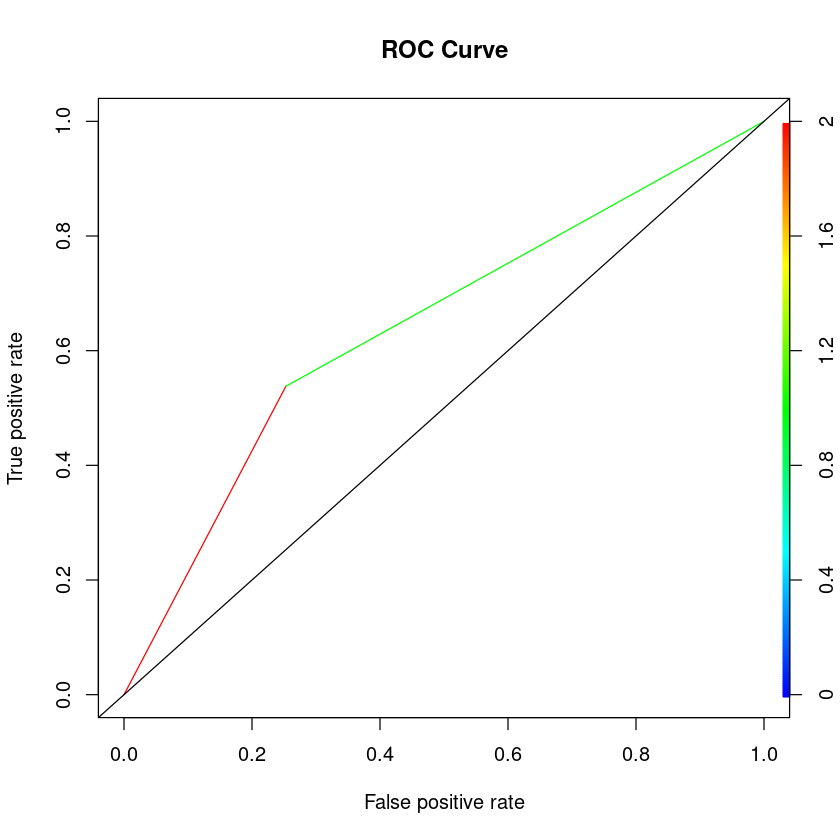

In [33]:
modelPerformance(helamodel1SMOTE, "LR", test, Class)

##### <a id=link9> 4.1.4 Both over- and under-sampling </a>

This model has slightly better specificity than the previous model. In tandem, we could also try yet another flavor of the *ovun.sample()* function - to have under- and over-sampling both in parallel. This could be a likely run like the SMOTE as above.

In [34]:
bothTrain <- ovun.sample(Class ~., data = train, method = "both", N= 1516620)$data
table(bothTrain$Class)


     0      1 
757715 758905 

In [35]:
helamodel1Both <- glm(formula = Class ~ CTCF + EP300 + H3K27me3 + H3K36me3 + H3K4me1 + H3K9me3 + RAD21 + RNA.Seq + RNAPol2 + RNAPol3,
               data = bothTrain,
               family = "binomial")
summary(helamodel1Both)

Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



Call:
glm(formula = Class ~ CTCF + EP300 + H3K27me3 + H3K36me3 + H3K4me1 + 
    H3K9me3 + RAD21 + RNA.Seq + RNAPol2 + RNAPol3, family = "binomial", 
    data = bothTrain)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-8.4904  -1.0912   0.0343   1.1692   1.5954  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.2941589  0.0034371 -85.583   <2e-16 ***
CTCF         0.0516589  0.0021696  23.811   <2e-16 ***
EP300        0.3203006  0.0042707  75.000   <2e-16 ***
H3K27me3    -0.1642664  0.0027568 -59.587   <2e-16 ***
H3K36me3     0.0908020  0.0020594  44.091   <2e-16 ***
H3K4me1      0.1327356  0.0020113  65.994   <2e-16 ***
H3K9me3     -0.1856204  0.0039389 -47.125   <2e-16 ***
RAD21        0.0014210  0.0011540   1.231    0.218    
RNA.Seq      0.0117648  0.0002704  43.516   <2e-16 ***
RNAPol2      0.0123449  0.0004717  26.169   <2e-16 ***
RNAPol3      0.0551590  0.0039267  14.047   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 

The confusion matrix is
         Actual
Predicted      0      1
        0 343000    307
        1 112077    353
The accuracy of the model is 75.34016 % 
The misclassification error of the model is 24.65984 % 
The sensitivity of the model is 75.37186 % 
The specificity of the model is 53.48485 % 
The area under curve is 0.6442835 
The statistical significance for the model is 0 
The confidence level for the model is 100 %

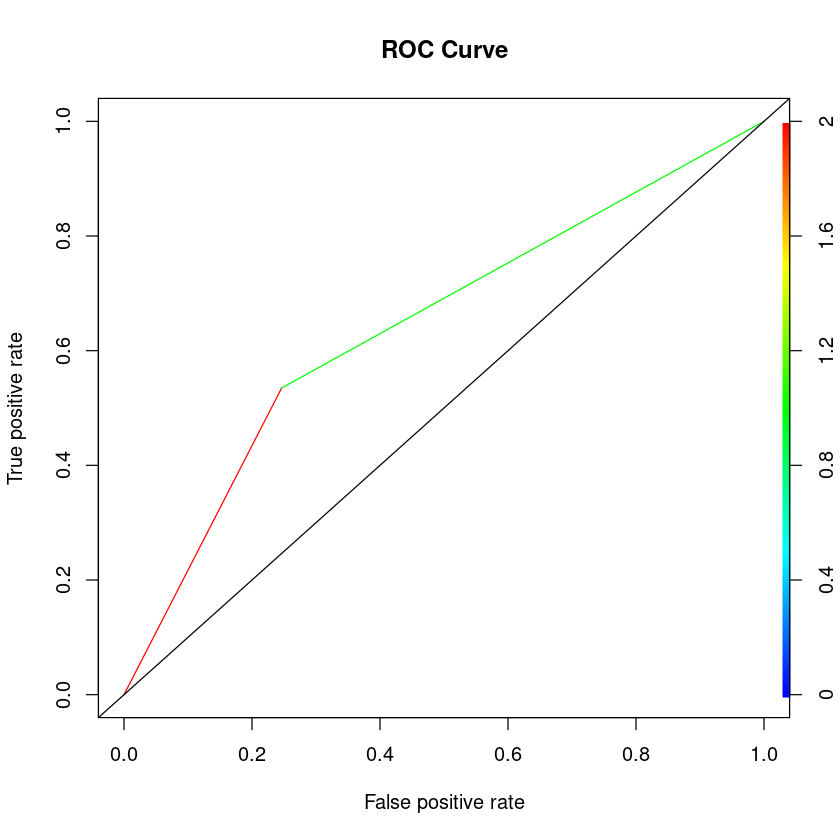

In [36]:
modelPerformance(helamodel1Both, "LR", test, Class)

These numbers are marginally better than the model with SMOTE data.

### <a id=link10>5. Ratifying the *Pareto's Principle* </a>

The 80:20 rule is omnipresent in the domains of business and economy. Hardly would have the italian economist known at the time that his [theory](https://en.wikipedia.org/wiki/Pareto_principle) would be rooted deeper than his perception. 

In [37]:
set.seed(6) # for reproducibility of results.
parts <- sample(2, nrow(helagreg),
               replace = TRUE,
               prob = c(0.8,0.2))
training <- helagreg[parts==1,]
testing <- helagreg[parts==2,]
cat("So, now we have", nrow(training), "training rows and", nrow(testing), "testing rows")

So, now we have 1215249 training rows and 303677 testing rows

With a new data partitioning, let's retrain the model with all variables. We'll check for multicollinear variables later.

In [38]:
helaparetoModel <- glm(formula = Class ~ ., 
                        data = training, 
                        family = "binomial")
summary(helaparetoModel)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



Call:
glm(formula = Class ~ ., family = "binomial", data = training)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.5820  -0.0560  -0.0545  -0.0524   3.8861  

Coefficients:
              Estimate Std. Error  z value Pr(>|z|)    
(Intercept) -6.501e+00  3.422e-02 -189.983  < 2e-16 ***
CTCF        -3.566e-02  1.607e-02   -2.219   0.0265 *  
EP300       -5.954e-03  3.246e-03   -1.834   0.0666 .  
H3K27me3    -2.251e-01  3.565e-02   -6.314 2.72e-10 ***
H3K36me3     9.776e-02  1.680e-02    5.818 5.95e-09 ***
H3K4me1      9.770e-02  1.158e-02    8.434  < 2e-16 ***
H3K4me2      8.676e-04  1.236e-02    0.070   0.9440    
H3K4me3      2.778e-02  1.354e-02    2.051   0.0402 *  
H3K9ac       3.385e-03  1.148e-02    0.295   0.7682    
H3K9me3     -1.888e-02  4.028e-02   -0.469   0.6393    
RAD21        3.562e-02  8.367e-03    4.257 2.07e-05 ***
RNA.Seq      2.349e-04  5.606e-04    0.419   0.6753    
RNAPol2     -6.232e-04  4.902e-03   -0.127   0.8988    
RNAPol3      2.32

In [39]:
vif(helaparetoModel)

CTCF    EP300 H3K27me3 H3K36me3  H3K4me1  H3K4me2  H3K4me3   H3K9ac 
2.240349 2.440988 6.723895 6.747002 1.740087 3.130837 8.339049 8.503705 
 H3K9me3    RAD21  RNA.Seq  RNAPol2  RNAPol3 
1.199591 3.214624 1.016901 2.958195 1.098568

From the inference above, we could omit the variable <b>H3K9ac</b> as it has a high VIF and also a high p-value.

In [40]:
helaparetoModel1 <- glm(formula = Class ~ CTCF + EP300 + H3K27me3 + H3K36me3 + H3K4me1 + H3K4me2 + H3K4me3 + H3K9me3 + RAD21 + RNA.Seq + RNAPol2 + RNAPol3, 
                        data = training, 
                        family = "binomial")
summary(helaparetoModel1)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



Call:
glm(formula = Class ~ CTCF + EP300 + H3K27me3 + H3K36me3 + H3K4me1 + 
    H3K4me2 + H3K4me3 + H3K9me3 + RAD21 + RNA.Seq + RNAPol2 + 
    RNAPol3, family = "binomial", data = training)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.5923  -0.0560  -0.0545  -0.0524   3.8859  

Coefficients:
              Estimate Std. Error  z value Pr(>|z|)    
(Intercept) -6.501e+00  3.423e-02 -189.906  < 2e-16 ***
CTCF        -3.631e-02  1.594e-02   -2.278 0.022731 *  
EP300       -5.919e-03  3.241e-03   -1.826 0.067828 .  
H3K27me3    -2.248e-01  3.568e-02   -6.301 2.97e-10 ***
H3K36me3     9.753e-02  1.679e-02    5.810 6.24e-09 ***
H3K4me1      9.793e-02  1.156e-02    8.472  < 2e-16 ***
H3K4me2      6.205e-04  1.232e-02    0.050 0.959818    
H3K4me3      3.075e-02  8.967e-03    3.429 0.000606 ***
H3K9me3     -1.876e-02  4.028e-02   -0.466 0.641397    
RAD21        3.579e-02  8.342e-03    4.290 1.78e-05 ***
RNA.Seq      2.376e-04  5.605e-04    0.424 0.671664    
RNAPol2 

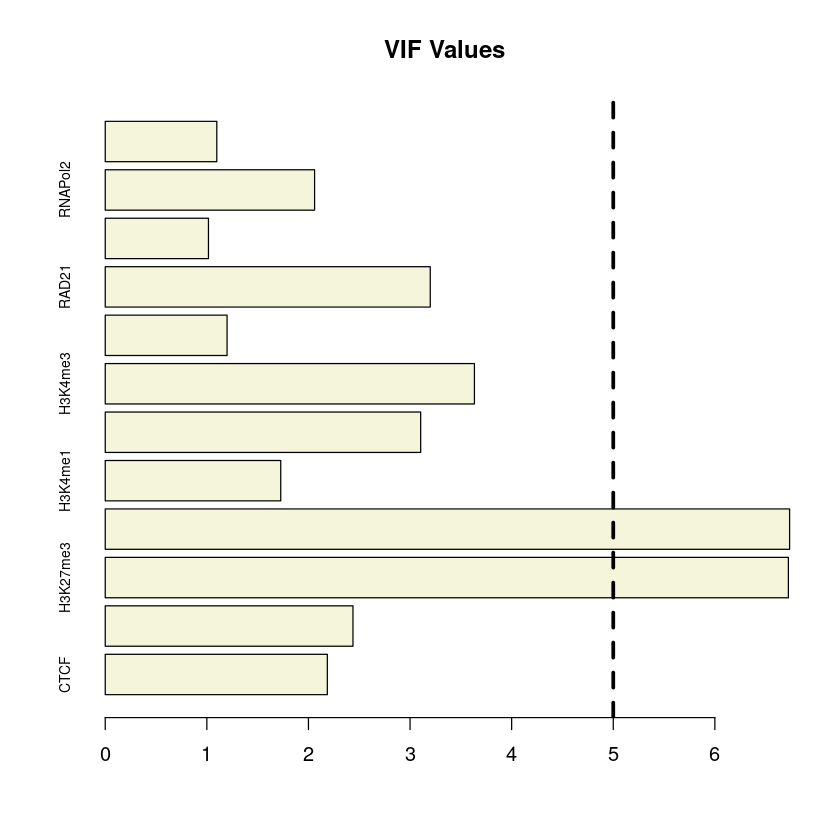

In [41]:
#create horizontal bar chart to display each VIF value
barplot(vif(helaparetoModel1), main = "VIF Values", horiz = TRUE, col = "beige", cex.names=.7)

#add vertical line at 5
abline(v = 5, lwd = 3, lty = 2)

The confusion matrix is
         Actual
Predicted      0      1
        0 303241    435
        1      1      0
The accuracy of the model is 99.85643 % 
The misclassification error of the model is 0.1435736 % 
The sensitivity of the model is 99.99967 % 
The specificity of the model is 0 % 
The area under curve is 0.4999984 
The statistical significance for the model is 1.397117e-42 
The confidence level for the model is 100 %

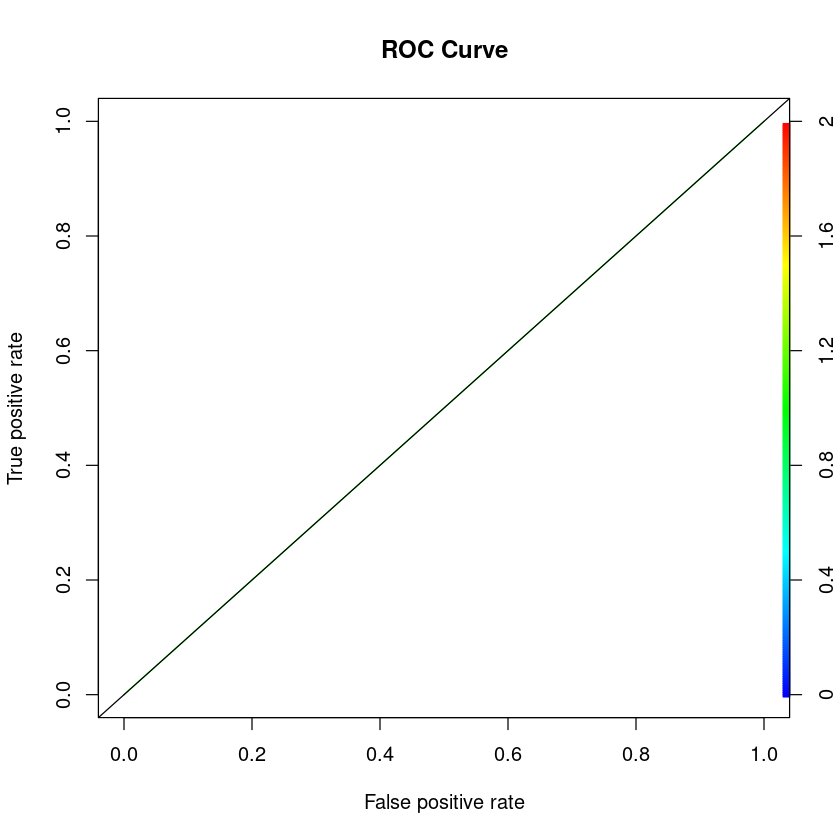

In [46]:
modelPerformance(helaparetoModel1, "LR", testing, Class)

We see here that the issue of class imbalance imposes skewness on the classifier to predict solely non-hubs (represented by "0"). The balancing of the data, as practiced above, might come to the rescue. Let's examine the performance of the classifier on SMOTE transformed data.

#### <a id=link11>5.1 SMOTE data </a>

In [43]:
training$Class <- as.factor(training$Class)
smoteDatum <- SMOTE(Class ~ CTCF + EP300 + H3K27me3 + H3K36me3 + H3K4me1 + H3K4me2 + H3K4me3 + H3K9me3 + RAD21 + RNA.Seq + RNAPol2 + RNAPol3, 
                    training, 
                    perc.over = 10000, 
                    k = 7, 
                    perc.under = 99)
table(smoteDatum$Class)


     0      1 
185229 188971 

In [44]:
helaparetoModel1Smote <- glm(formula = Class ~ CTCF + EP300 + H3K27me3 + H3K36me3 + H3K4me1 + H3K4me2 + H3K4me3 + H3K9me3 + RAD21 + RNA.Seq + RNAPol2 + RNAPol3, 
                             data = smoteDatum, 
                             family = "binomial")
summary(helaparetoModel1Smote)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



Call:
glm(formula = Class ~ CTCF + EP300 + H3K27me3 + H3K36me3 + H3K4me1 + 
    H3K4me2 + H3K4me3 + H3K9me3 + RAD21 + RNA.Seq + RNAPol2 + 
    RNAPol3, family = "binomial", data = smoteDatum)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-8.4904  -1.0917   0.2532   1.1591   1.8248  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.3513622  0.0066118 -53.142  < 2e-16 ***
CTCF         0.0210017  0.0043624   4.814 1.48e-06 ***
EP300        0.4282157  0.0086901  49.277  < 2e-16 ***
H3K27me3    -0.1371874  0.0046598 -29.441  < 2e-16 ***
H3K36me3     0.1473137  0.0039885  36.935  < 2e-16 ***
H3K4me1      0.1391937  0.0044433  31.327  < 2e-16 ***
H3K4me2     -0.2091619  0.0047396 -44.131  < 2e-16 ***
H3K4me3      0.1730627  0.0040596  42.631  < 2e-16 ***
H3K9me3     -0.1368641  0.0069547 -19.679  < 2e-16 ***
RAD21        0.0118221  0.0024280   4.869 1.12e-06 ***
RNA.Seq      0.0027791  0.0004909   5.661 1.50e-08 ***
RNAPol2     -0.009

The confusion matrix is
         Actual
Predicted      0      1
        0 219496    198
        1  83746    237
The accuracy of the model is 72.35747 % 
The misclassification error of the model is 27.64253 % 
The sensitivity of the model is 72.38311 % 
The specificity of the model is 54.48276 % 
The area under curve is 0.6343294 
The statistical significance for the model is 0 
The confidence level for the model is 100 %

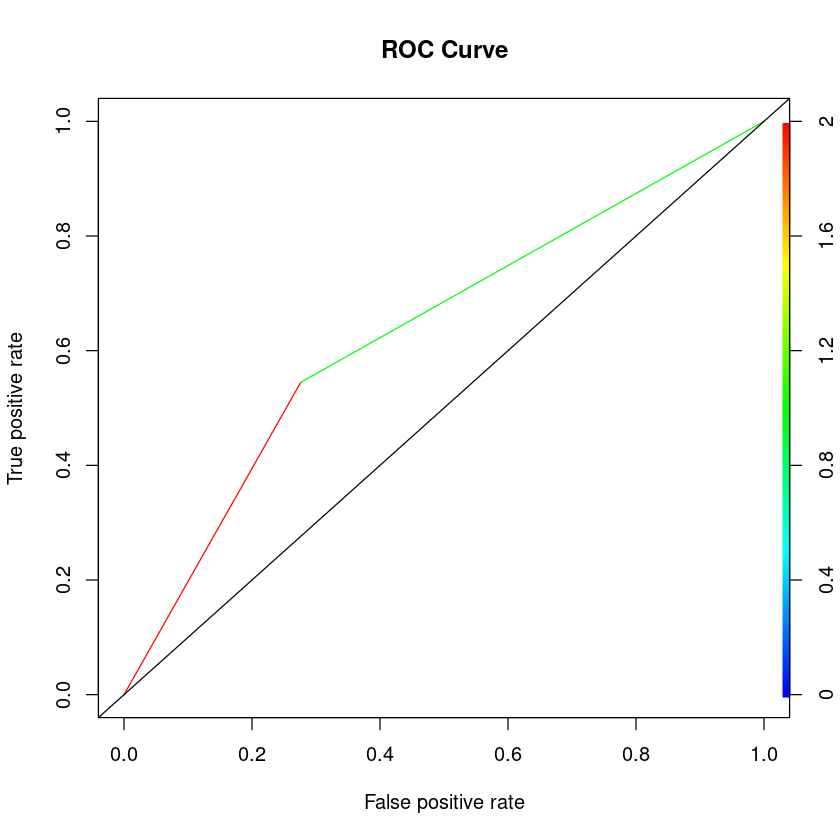

In [47]:
modelPerformance(helaparetoModel1Smote, "lr", testing, Class)

### <a id=link12>6. Visualizing Predictions </a>

We choose to go with a previous model and will save the prediction results, that shall be later utilized for plotting.

In [48]:
helaModel1Predictions <- predict(helamodel1Both, helagreg, type = "response")
helaModel1PredictionsProbs <- ifelse(helaModel1Predictions > 0.5, 1, 0)

Eventually, we have the original dataset with the classes and the one with the model predictions. We attempt to map the prediction results corresponding to LR-Hubs from the HeLa cell-line. It will be interesting to see the intersect of the pre-caliberated LR-Hubs and the ones predicted by the classifier.

The workflow commences with the installation of <a href = "http://www.bioconductor.org/packages/release/bioc/html/Gviz.html" > Gviz</a> - the package we aim to deploy for the visualization.

In [49]:
if(!requireNamespace("BiocManager", quietly = TRUE))
BiocManager::install("Gviz")
suppressPackageStartupMessages(library(Gviz))

Next, we recall the data from the HeLa cell-line (GREG). We already know, this is a comprehensive data (genome-wide) with values corresponding to epigenetic marks (features) for each bin (a 2Kb genomic region), in addition to a "Class", i.e. a "Hub" or a "Non-Hub". For the present case, we shall prune the data for the genomic intervals and their corresponding class. That is all we need!

In [50]:
helagregStandardRegionsClass <- helagregStandard[, c(1:3,17)]

Also, considering the computational resources we deploy, we shall focus on chromosome 21 only.

In [51]:
# Extracting chr21 data

helagregChr21NonHub <- helagregStandardRegionsClass[helagregStandardRegionsClass$chr=="chr21" & helagregStandardRegionsClass$Class=="Non-Hub", ] ## subset of data for exemplifying
helagregChr21Hub <- helagregStandardRegionsClass[helagregStandardRegionsClass$chr=="chr21" & helagregStandardRegionsClass$Class=="Hub", ]

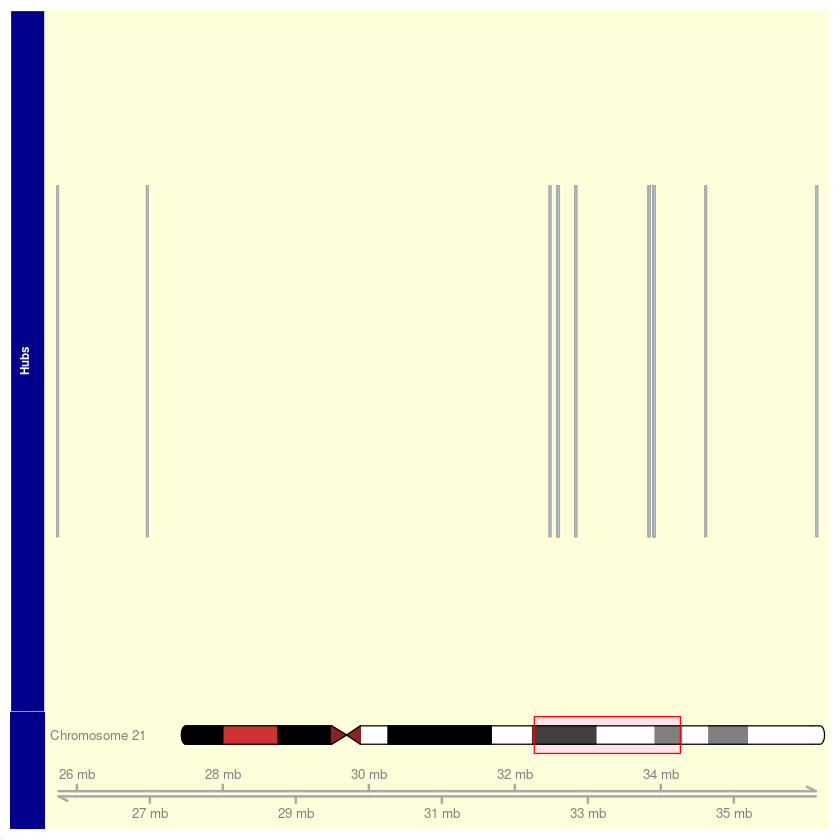

In [52]:
# Plotting Hubs

annotationTrackHub <- AnnotationTrack(range = helagregChr21Hub, 
                                      name = "Hubs", 
                                      genome = "hg38", 
                                      chromosome = "chr21")
itrack <- IdeogramTrack(genome = "hg38", chromosome = "chr21")
genomeTrack <- GenomeAxisTrack()
plotTracks(list(annotationTrackHub, itrack, genomeTrack), 
           background.panel = "#FFFEDB", 
           background.title = "darkblue",
           stacking = "dense")

So, there is a narrow occurrence of "hubs" in the chromosome 21, as seen above. The specific locations are given below.

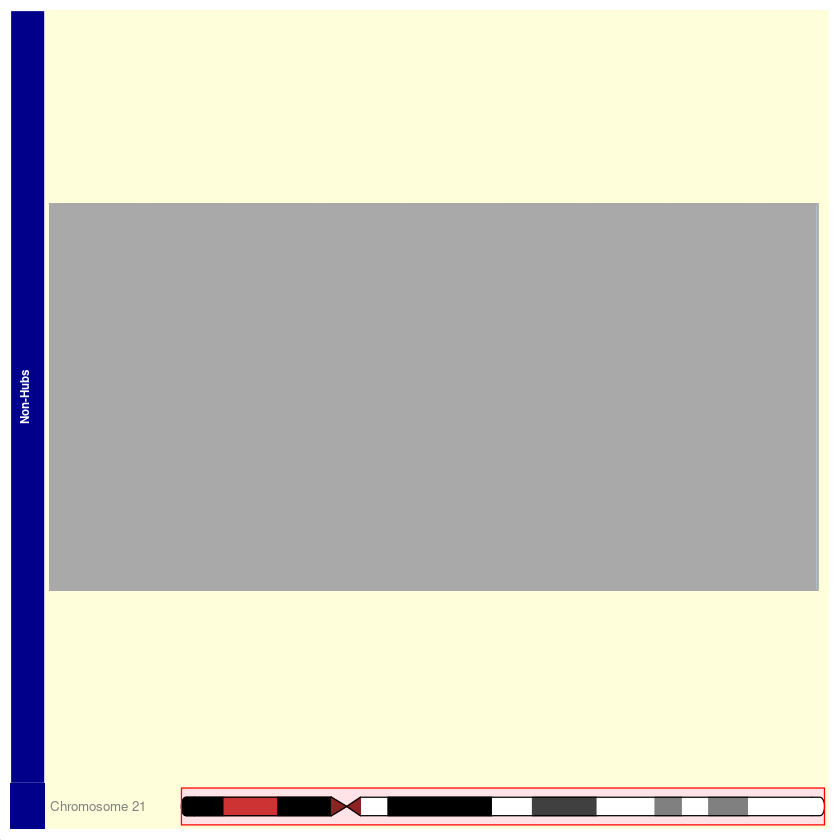

In [53]:
# Plotting Non-Hubs

annotationTrackNonHub <- AnnotationTrack(range = helagregChr21NonHub, 
                                         name = "Non-Hubs", 
                                         genome = "hg38", 
                                         chromosome = "chr21")
itrack <- IdeogramTrack(genome = "hg38", chromosome = "chr21")
plotTracks(list(annotationTrackNonHub, itrack),
           background.panel = "#FFFEDB", 
           background.title = "darkblue",
           stacking = "dense")

In contrast, we are curious to examine if the findings of the classifier are able to fortify the original class definitions. Let us frame the data from the predicted results.  

In [54]:
helagregPredicted <- cbind(helagregStandardRegionsClass, helaModel1PredictionsProbs)
names(helagregPredicted)[names(helagregPredicted)=="helaModel1PredictionsProbs"] <- "Prediction"
helagregPredicted$Prediction <- ifelse(helagregPredicted$Prediction == 1, "Hub", "Non-Hub")            

Let us see if the classifier predictions match with the original results.

In [55]:
helagregChr21PredicitedHub <- helagregPredicted[helagregPredicted$chr=="chr21" & helagregPredicted$Prediction=="Hub", ]

Certainly, the predicted hubs are far more in number and there are noticeable instances of "Non-Hubs" that have been classified as "Hubs", with the given profile of the classification model.  

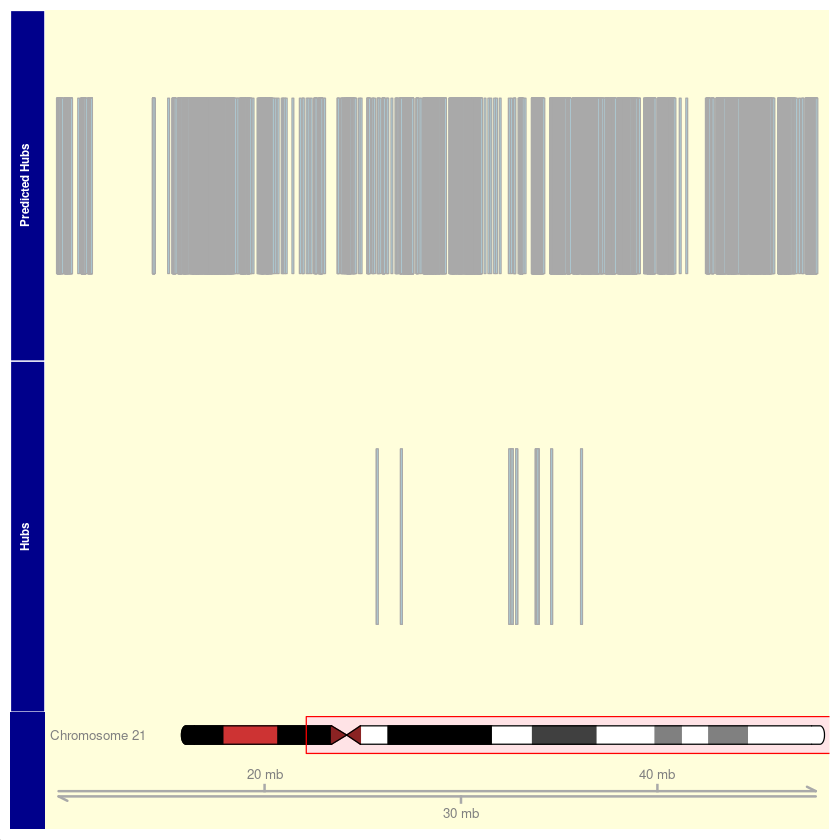

In [56]:
# Plotting Predicted Hubs
annotationTrackHub <- AnnotationTrack(range = helagregChr21Hub, 
                                      name = "Hubs", 
                                      genome = "hg38", 
                                      chromosome = "chr21")
annotationTrackPredictedHub <- AnnotationTrack(range = helagregChr21PredicitedHub, 
                                               name = "Predicted Hubs", 
                                               genome = "hg38", 
                                               chromosome = "chr21")
itrack <- IdeogramTrack(genome = "hg38", chromosome = "chr21")
genomeTrack <- GenomeAxisTrack()
plotTracks(list(annotationTrackPredictedHub,annotationTrackHub, itrack, genomeTrack), 
           background.panel = "#FFFEDB", 
           background.title = "darkblue",
           stacking = "dense")

Exactly, what classes ...

In [57]:
helagregChr21PredicitedHub[helagregChr21PredicitedHub$Class == helagregChr21PredicitedHub$Prediction , ]

,chr,start,end,Class,Prediction
,<fct>,<int>,<int>,<fct>,<chr>
810642,chr21,26964001,26966000,Hub,Hub
810643,chr21,26966001,26968000,Hub,Hub
814077,chr21,33834001,33836000,Hub,Hub
814078,chr21,33836001,33838000,Hub,Hub
814079,chr21,33838001,33840000,Hub,Hub
814080,chr21,33840001,33842000,Hub,Hub
814081,chr21,33842001,33844000,Hub,Hub
814472,chr21,34612001,34614000,Hub,Hub
814473,chr21,34614001,34616000,Hub,Hub


In [58]:
truePositives <- helagregPredicted[helagregPredicted$Class == helagregPredicted$Prediction, ]

As we close, we'll save the optimal model and true positive genomic regions (hubs) as explicit R data objects, in order to recall for later use.

In [59]:
## Saving relevant files

save(helamodel1Both, file = "./optimalModels/helamodelLR") # optimal model
write.table(truePositives, file = "./truePositives/helaLR.txt", quote = FALSE) # true positives: precicted ~ original
write.table(bothTrain, file = "./buildData/optimalModelTrainHeLa.txt", quote = FALSE) # data used to train model
write.table(test, file = "./buildData/optimalModelTestHeLa.txt", quote = FALSE) # data used to test model

### Conclusion

We see that the best performing model isn't just graded by its accuracy (which is corresponding to the current state of class distribution), but by how well it is able to differentiate between the negative and positive classes. Considering the same as premise, we identified that the following is the best performing model with related attributes.

| Best Model | Accuracy | Sensitivity | Specificity | Remark
| --- | --- | --- | --- | ---
| helamodel1Both | 75.34016 % | 75.37186 % | 53.48485 % | Good

Also, note that data on which the model was trained has a distribution of 757715:758905 in class proportion, which is 0.998431951 (~1). So, the probability of finding any class is 50% (ideally) because we have a near homogeneous spread of class labels. 

### <a id=link13>7. Session Information </a>

In [60]:
sessionInfo()

R version 3.6.0 (2019-04-26)
Platform: x86_64-redhat-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /usr/lib64/R/lib/libRblas.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] parallel  stats4    grid      stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] Gviz_1.30.3          GenomicRanges_1.38.0 GenomeInfoDb_1.22.1 
 [4] IRanges_2.20.2       S4Vectors_0.24.4     BiocGenerics_0.32.0 
 [7] ROCR_1.0-11          DMwR_0.4.1           ROSE_0.0-3          
[10] e1071_1.7-3          caret_6.0-86         rms_6.0-1           
[13] SparseM_1.78         H